<a href="https://colab.research.google.com/github/sehee020512/20242R0136COSE47402/blob/master/final%20project%2012.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [1]:
!pip install pillow
!pip install transformers
!pip install matplotlib
!pip install timm

In [2]:
import kagglehub
import shutil
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.nn as nn
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torchvision
import torchvision.transforms as T
from sklearn.metrics import accuracy_score
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [3]:
path = kagglehub.dataset_download("kavyasreeb/hair-type-dataset")

print("Path to dataset files:", path)

100%|██████████| 175M/175M [00:09<00:00, 19.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1


In [4]:
# 원본 데이터 경로
source_path = "/root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1"

# 복사할 대상 경로
destination_path = "/content/hair-type-dataset"

# 데이터 복사
try:
    shutil.copytree(source_path, destination_path)
    print(f"데이터가 {destination_path}에 복사되었습니다.")
except Exception as e:
    print(f"복사 실패: {e}")

데이터가 /content/hair-type-dataset에 복사되었습니다.


In [5]:
# 데이터 경로 설정
dataset_dir = "/content/hair-type-dataset/data"  # 클래스별 이미지가 있는 디렉토리
train_dir = "/content/train"  # train 데이터 저장 경로
test_dir = "/content/test"  # test 데이터 저장 경로

# train/test 디렉토리 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 이미지 확장자 필터
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# 클래스별 train/test 데이터 분리
split_ratio = 0.8  # Train 80%, Test 20%
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if not os.path.isdir(category_path):
        continue  # 디렉토리가 아니면 건너뜀

    # 클래스별 이미지 파일 가져오기
    images = [img for img in os.listdir(category_path) if img.lower().endswith(valid_extensions)]

    # 이미지가 없으면 건너뜀
    if len(images) == 0:
        print(f"'{category}' 폴더에 이미지가 없습니다. 건너뜁니다.")
        continue

    # train/test로 분리
    train_images, test_images = train_test_split(images, test_size=1 - split_ratio, random_state=42)

    # 클래스별 train/test 디렉토리 생성
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # train 이미지 이동
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))

    # test 이미지 이동
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

    print(f"'{category}' 클래스에서 Train: {len(train_images)}개, Test: {len(test_images)}개 파일이 이동되었습니다.")

print("Train/Test 데이터 분리가 완료되었습니다!")

'dreadlocks' 클래스에서 Train: 354개, Test: 89개 파일이 이동되었습니다.
'Wavy' 클래스에서 Train: 263개, Test: 66개 파일이 이동되었습니다.
'curly' 클래스에서 Train: 411개, Test: 103개 파일이 이동되었습니다.
'kinky' 클래스에서 Train: 173개, Test: 44개 파일이 이동되었습니다.
'Straight' 클래스에서 Train: 388개, Test: 97개 파일이 이동되었습니다.
Train/Test 데이터 분리가 완료되었습니다!


In [6]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DeiT 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Fine-Tuning with Early Stopping

## Fine-Tuning with Freezing Blocks

In [7]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model.head = nn.Linear(model.head.in_features, 5)

torch.nn.init.xavier_uniform_(model.head.weight)
torch.nn.init.zeros_(model.head.bias)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [8]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 (옵션)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 동결된 파라미터와 학습 가능한 파라미터 확인
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"{name}: requires_grad={param.requires_grad}")

In [9]:
# device 설정: GPU가 사용 가능하면 GPU, 아니면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)  # 모델을 지정된 device로 이동

Using device: cuda


In [10]:
test_images = []
test_labels = []  # 실제 레이블 저장
predicted_labels = []  # 예측된 레이블 저장

# 하위 폴더를 순회하며 이미지와 레이블을 로드
try:
    label_mapping = {label: idx for idx, label in enumerate(sorted(os.listdir(test_dir)))}
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.lower().endswith(valid_extensions):  # 유효한 이미지 파일인지 확인
                try:
                    # 폴더 이름을 레이블로 사용
                    label = label_mapping[category]
                    test_labels.append(label)

                    # 이미지 열기 및 전처리
                    img = Image.open(file_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0).to(device)  # 배치 차원 추가

                    # 모델 예측
                    with torch.no_grad():
                        output = model(img_tensor)
                        predicted_class = torch.argmax(output, dim=1).item()

                    # 예측된 레이블 저장
                    predicted_labels.append(predicted_class)
                except Exception as e:
                    print(f"이미지 처리 실패: {file_name}, 오류: {e}")
except Exception as e:
    print(f"테스트 데이터 로드 중 오류 발생: {e}")

In [11]:
# 4. 정확도 계산 및 출력
if test_labels and predicted_labels:
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"테스트 데이터 개수: {len(test_labels)}")
    print(f"정확도: {accuracy * 100:.2f}%")

    # 예측 결과 예시 출력
    for i in range(len(test_labels)):
        true_label = reverse_mapping[test_labels[i]]
        predicted_label = reverse_mapping[predicted_labels[i]]
else:
    print("테스트 데이터가 비어 있거나 예측 결과가 없습니다.")

테스트 데이터 개수: 399
정확도: 22.81%


In [12]:
img_tensor = img_tensor.to(device)  # 이미지를 동일한 device로 이동

In [13]:
def log_gradients_and_freeze(model, freeze_threshold):
    gradient_logs = []  # 각 블록의 Gradient 정보를 저장
    all_frozen = True  # 모든 블록이 frozen 상태인지 확인

    for idx, block in enumerate(model.blocks):
        # 이미 frozen된 블록은 건너뜀
        if not any(param.requires_grad for param in block.parameters()):
            gradient_logs.append(0.0)  # Frozen 블록의 Gradient를 0으로 처리
            continue

        # Frozen되지 않은 블록이 존재하면 all_frozen은 False
        all_frozen = False

        total_grad = 0.0
        num_params = 0
        for param in block.parameters():
            if param.grad is not None:
                total_grad += param.grad.norm().item()  # 기울기의 L2 노름 계산
                num_params += 1
        avg_grad = total_grad / max(1, num_params)  # 평균 기울기
        gradient_logs.append(avg_grad)

        # Freezing 조건
        if avg_grad < freeze_threshold:
            for param in block.parameters():
                param.requires_grad = False
            print(f"Block {idx} is frozen (Gradient: {avg_grad:.6f}).")

    return gradient_logs, all_frozen

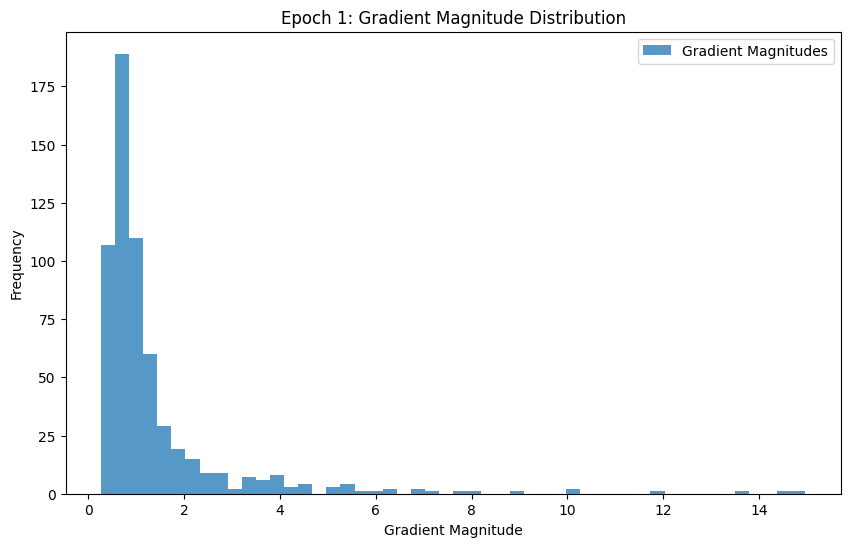

Epoch [1], Loss: 0.9534, Accuracy: 69.65%, Duration: 25.26 seconds


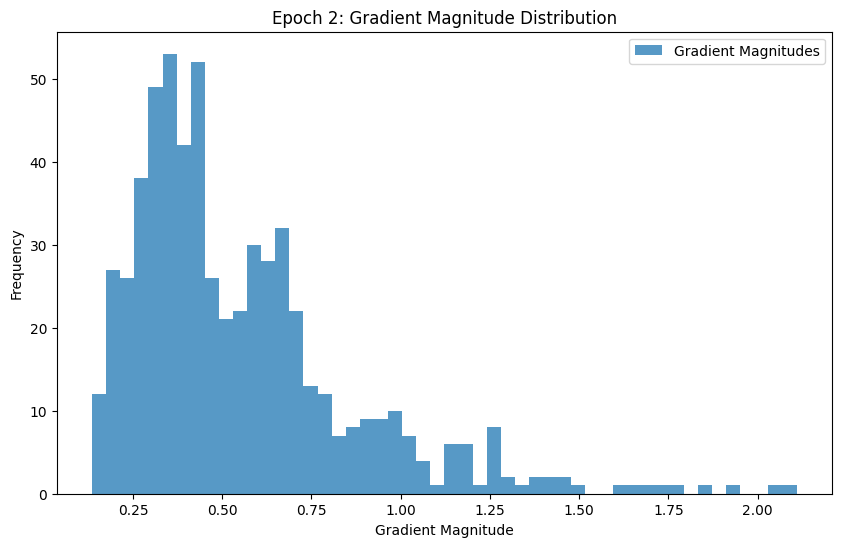

Epoch [2], Loss: 0.2511, Accuracy: 90.30%, Duration: 24.47 seconds


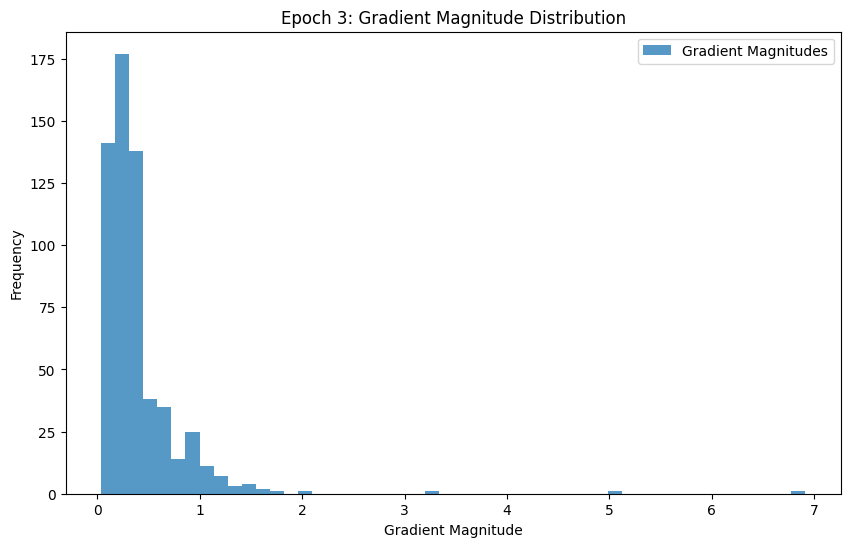

Epoch [3], Loss: 0.1324, Accuracy: 95.09%, Duration: 25.18 seconds


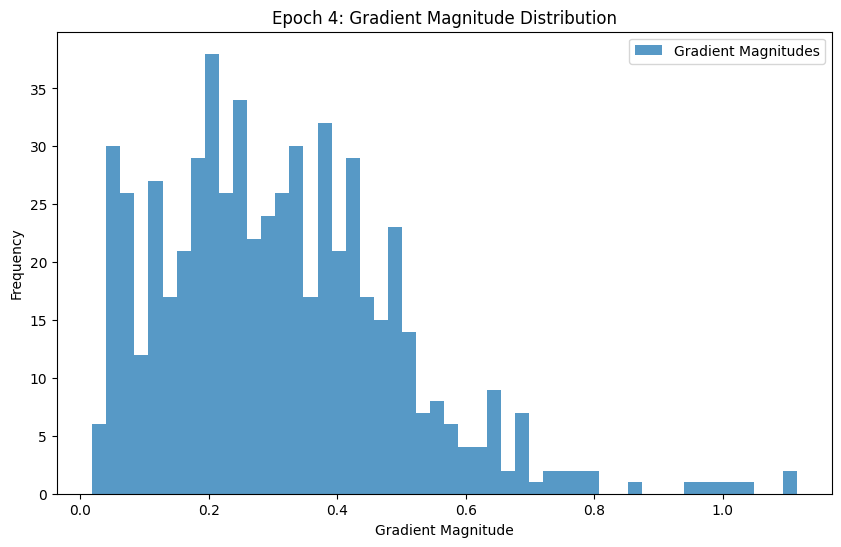

Epoch [4], Loss: 0.1214, Accuracy: 95.65%, Duration: 24.50 seconds


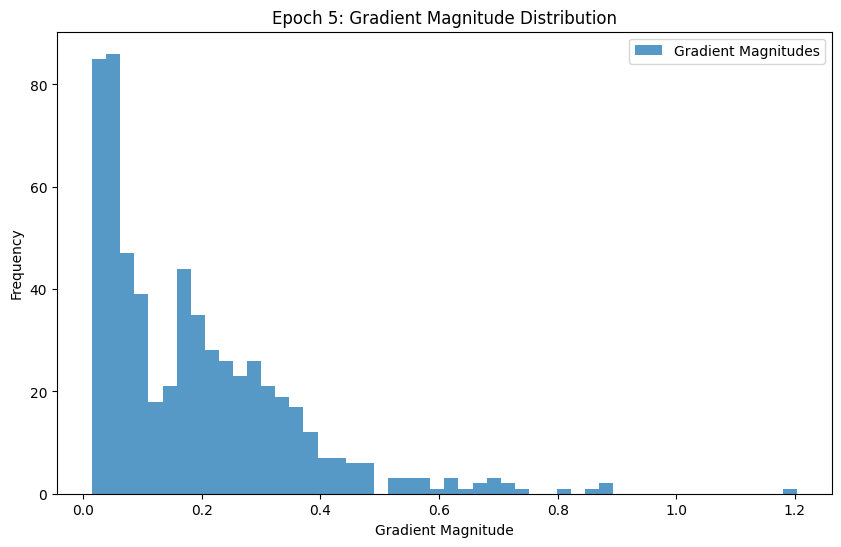

Epoch [5], Loss: 0.0591, Accuracy: 98.17%, Duration: 24.74 seconds


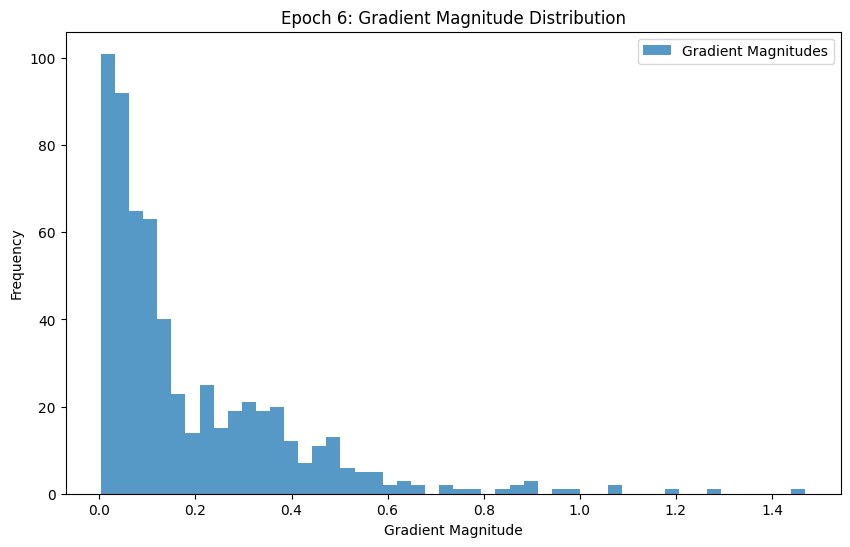

Epoch [6], Loss: 0.0481, Accuracy: 98.36%, Duration: 24.54 seconds


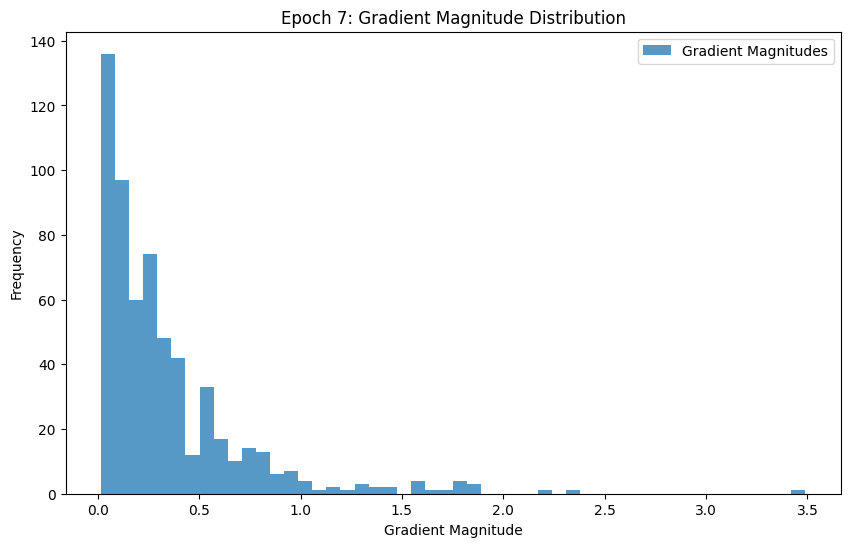

Epoch [7], Loss: 0.1094, Accuracy: 96.66%, Duration: 24.59 seconds
Block 11 is frozen (Gradient: 0.000730).


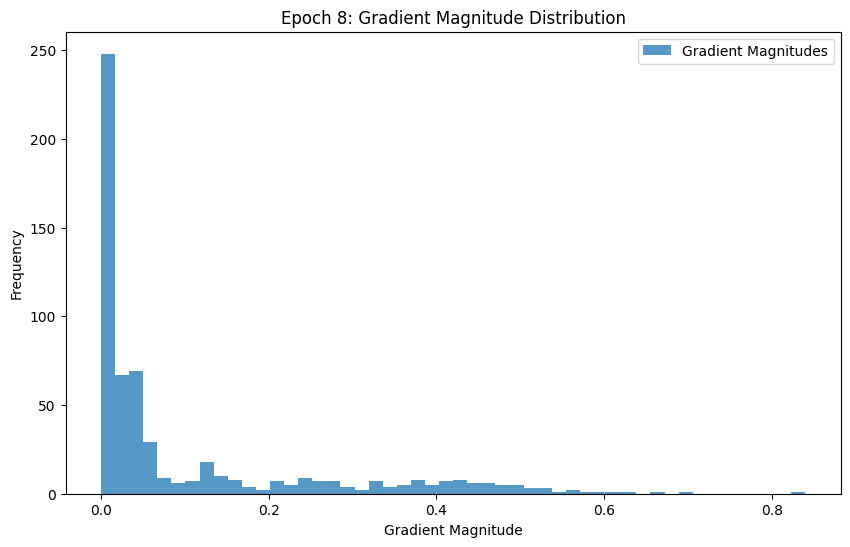

Epoch [8], Loss: 0.0278, Accuracy: 99.12%, Duration: 24.53 seconds
Block 0 is frozen (Gradient: 0.000629).
Block 1 is frozen (Gradient: 0.000467).
Block 2 is frozen (Gradient: 0.000439).
Block 3 is frozen (Gradient: 0.000419).
Block 4 is frozen (Gradient: 0.000479).
Block 5 is frozen (Gradient: 0.000478).
Block 6 is frozen (Gradient: 0.000491).
Block 7 is frozen (Gradient: 0.000502).
Block 8 is frozen (Gradient: 0.000530).
Block 9 is frozen (Gradient: 0.000656).
Block 10 is frozen (Gradient: 0.000818).


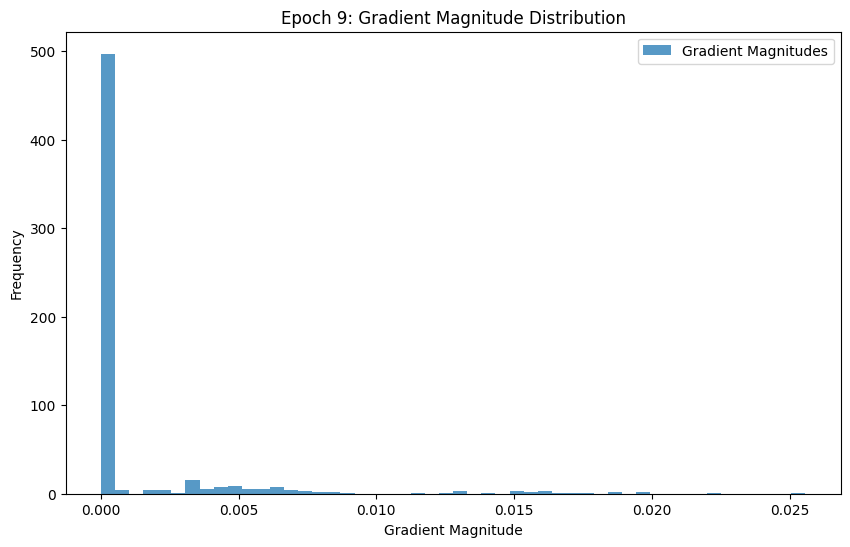

Epoch [9], Loss: 0.0078, Accuracy: 99.81%, Duration: 21.35 seconds
All blocks are frozen. Training stopped at Epoch 9.
Fine-Tuning 완료!


In [14]:
# 학습 루프
freeze_threshold = 1e-3  # 블록을 freezing할 기울기 크기 임계값
epoch = 0  # 에포크 수 초기화

while True:
    epoch += 1  # 에포크 증가
    start_time = time.time()  # 에포크 시작 시간 기록

    model.train()  # 모델 학습 모드
    running_loss = 0.0
    correct = 0
    total = 0
    max_gradients = []  # 모든 블록의 Gradient Magnitude 기록용 리스트

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 및 손실 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파
        loss.backward()

        # Gradient 크기 로깅 및 Freezing
        gradient_logs, all_frozen = log_gradients_and_freeze(model, freeze_threshold)
        max_gradients.extend(gradient_logs)  # Gradient Magnitudes 누적

        # 옵티마이저 업데이트
        optimizer.step()

        # 손실 및 정확도 계산
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Gradient Magnitude 히스토그램 출력
    plt.figure(figsize=(10, 6))
    plt.hist(max_gradients, bins=50, alpha=0.75, label='Gradient Magnitudes')
    plt.title(f"Epoch {epoch}: Gradient Magnitude Distribution")
    plt.xlabel("Gradient Magnitude")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 에포크 종료 시간 기록
    end_time = time.time()
    epoch_duration = end_time - start_time  # 에포크 소요 시간 계산

    print(f"Epoch [{epoch}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100.*correct/total:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # 학습률 스케줄러 업데이트 (옵션)
    scheduler.step()

    # 모든 블록이 frozen 상태라면 학습 종료
    if all_frozen:
        print(f"All blocks are frozen. Training stopped at Epoch {epoch}.")
        break

# 학습 완료
print("Fine-Tuning 완료!")

In [15]:
# 모델 평가 모드
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"테스트 데이터 정확도: {100.*correct/total:.2f}%")

테스트 데이터 정확도: 91.48%
